In [210]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
from scipy.optimize import minimize
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [211]:
num_stocks = int(input("Number of stocks in the portfolio?"))

number = ['first', 'second', 'thirth', 'fourth', 'fifth', 'sixth', 'seventh', 'eight', 'ninth', 'tenth']
stocks = []

for num in range (num_stocks):
    stocks.append(input("Name of the " + number[num] + " stock?"))
print(stocks)


Number of stocks in the portfolio?10
Name of the first stock?AAPL
Name of the second stock?AMZN
Name of the thirth stock?CSCO
Name of the fourth stock?CVS
Name of the fifth stock?DIS
Name of the sixth stock?GOOGL
Name of the seventh stock?JPM
Name of the eight stock?MSFT
Name of the ninth stock?V
Name of the tenth stock?WFC
['AAPL', 'AMZN', 'CSCO', 'CVS', 'DIS', 'GOOGL', 'JPM', 'MSFT', 'V', 'WFC']


In [334]:
investment_duration = float(input('How many years would this portfolio investment hold? (can be fraction)'))
expected_daily_returns = []
for num in range(num_stocks):
    expected_daily_returns.append(float(input("The expected return of " + stocks[num] + " in the investment period?"))/(investment_duration*252))

return_target = float(input("What is the target return in the investment period?"))/investment_duration
expected_annual_returns = [i*252 for i in expected_daily_returns]
print("Expected annual return: " + str(expected_annual_returns))

How many years would this portfolio investment hold? (can be fraction)0.5
The expected return of AAPL in the investment period?0.10
The expected return of AMZN in the investment period?0.19
The expected return of CSCO in the investment period?0.07
The expected return of CVS in the investment period?0.15
The expected return of DIS in the investment period?0.044
The expected return of GOOGL in the investment period?0.055
The expected return of JPM in the investment period?0.13
The expected return of MSFT in the investment period?0.06
The expected return of V in the investment period?0.037
The expected return of WFC in the investment period?0.14
What is the target return in the investment period?0.11
Expected annual return: [0.2, 0.38, 0.14, 0.3, 0.088, 0.11, 0.26, 0.12, 0.074, 0.28]


In [335]:
print(max(expected_daily_returns)*252)

0.38


In [336]:
quandl.ApiConfig.api_key = 'PrW6L55BexiSBEqWU25u'
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,WFC,60.67
1,2017-12-28,WFC,61.30
2,2017-12-27,WFC,60.95
3,2017-12-26,WFC,61.13
4,2017-12-22,WFC,61.55


In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5018 entries, 0 to 5017
Data columns (total 3 columns):
date         5018 non-null datetime64[ns]
ticker       5018 non-null object
adj_close    5018 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 117.7+ KB


In [338]:
df = data.set_index('date')
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,CSCO,CVS,DIS,GOOGL,JPM,MSFT,V,WFC
date,,,,,,,,,,
2016-01-04,101.783763,636.99,24.829514,92.361768,100.716586,759.44,60.836558,52.181598,74.736078,49.843256
2016-01-05,99.233131,633.79,24.716696,92.629872,98.682302,761.53,60.941745,52.419653,75.298820,49.824416
2016-01-06,97.291172,632.65,24.453452,91.500006,98.154171,759.33,60.061996,51.467434,74.311553,48.872957
2016-01-07,93.185040,607.94,23.889359,90.178637,97.313073,741.00,57.633124,49.677262,72.850399,47.478740
2016-01-08,93.677776,607.05,23.297061,89.584979,97.068568,730.91,56.342188,49.829617,71.951986,46.687427


Text(0.5, 1.0, 'Past performance of price in $')

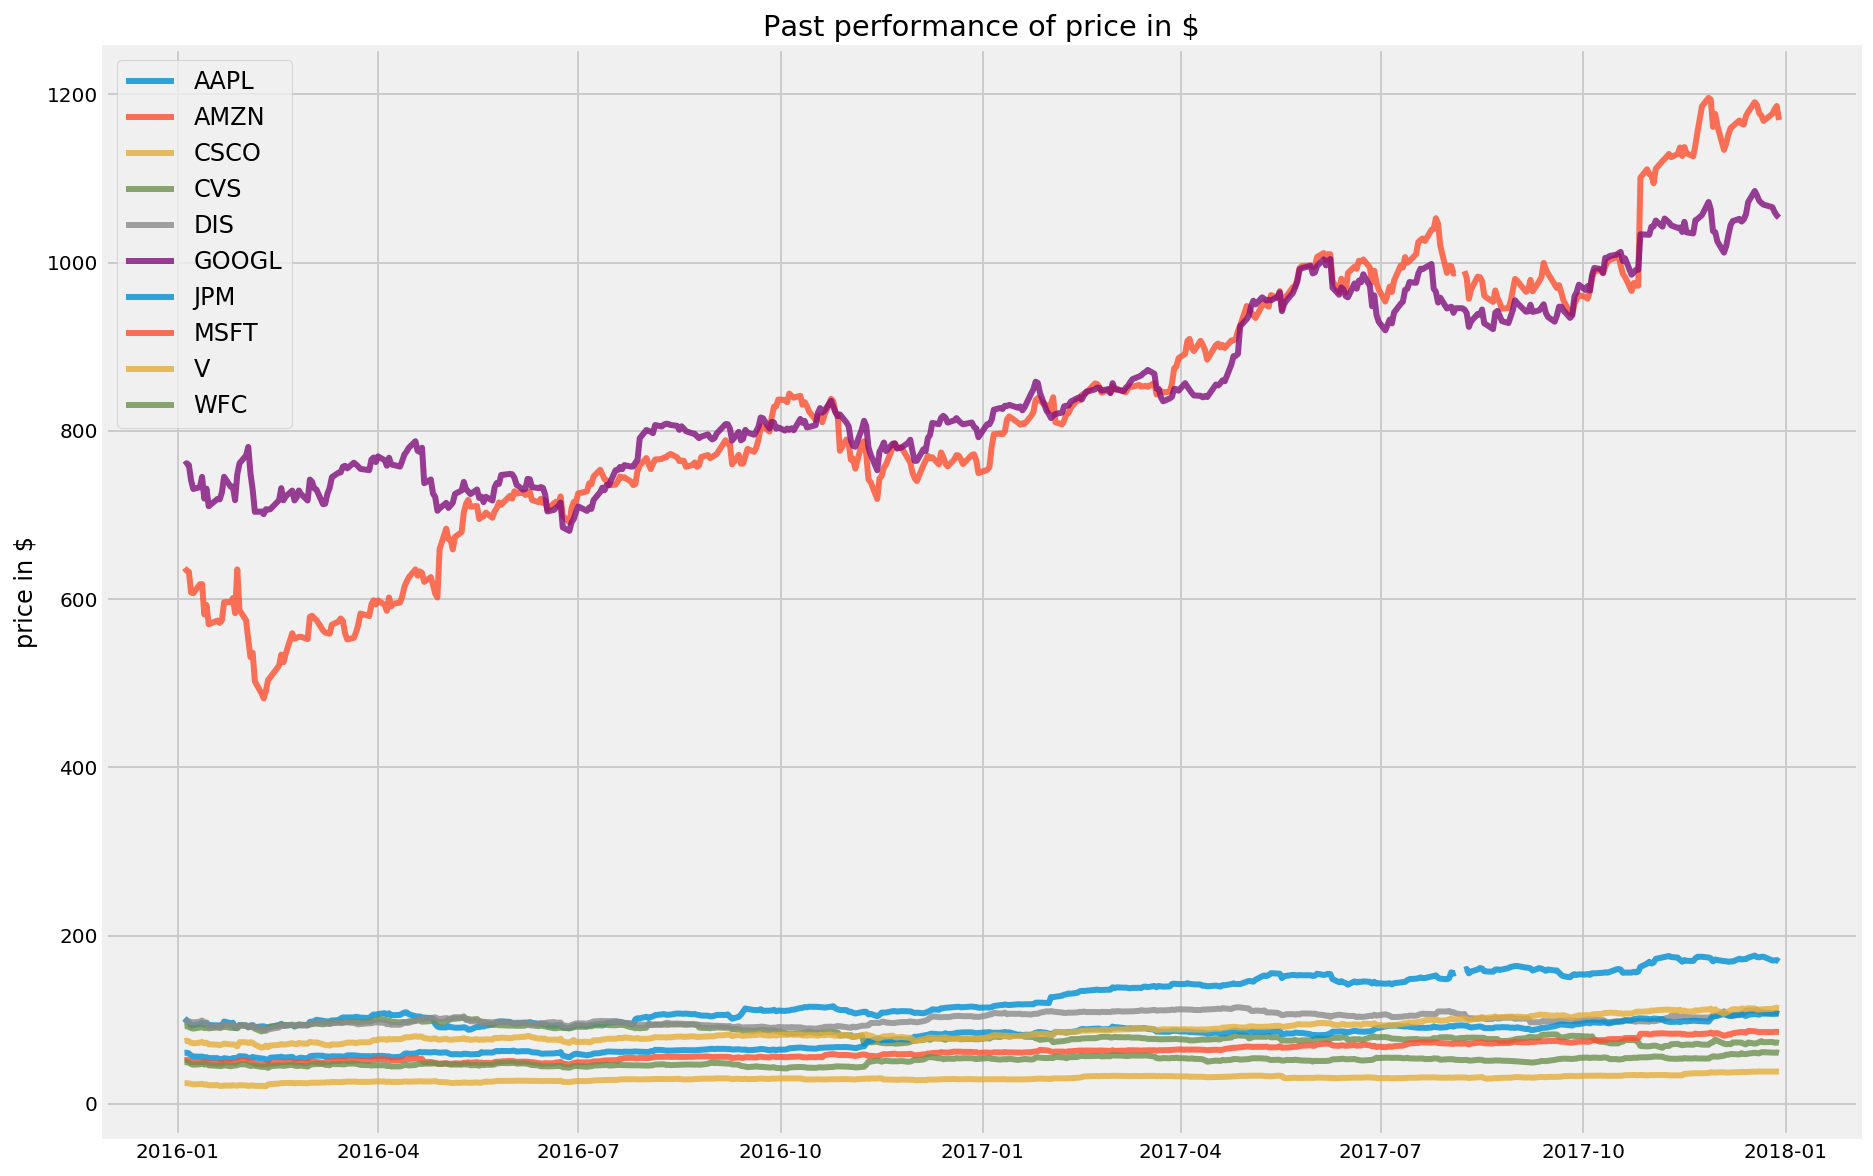

In [339]:
plt.figure(figsize=(14, num_stocks))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')
plt.title('Past performance of price in $')

Text(0.5, 1.0, 'Past performance on daily returns')

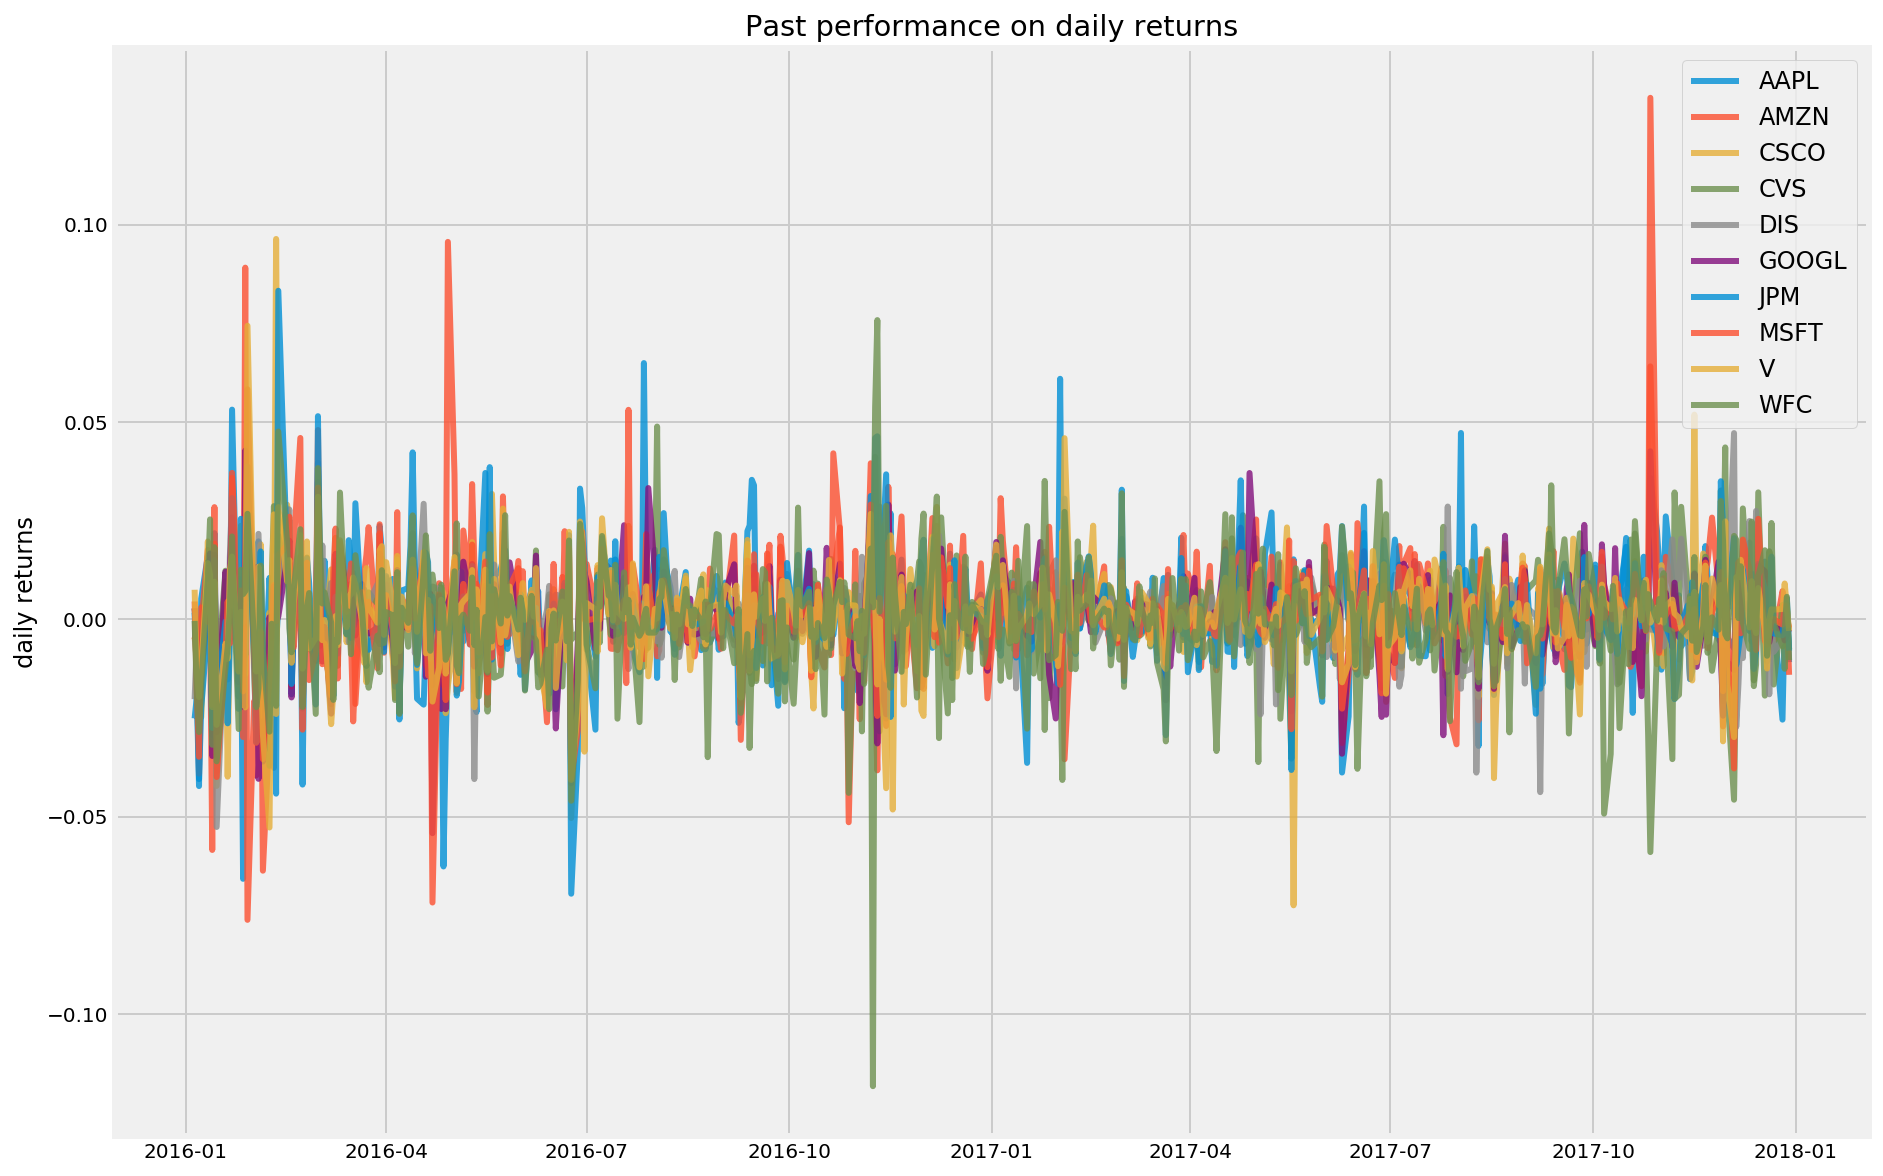

In [340]:
returns = table.pct_change()
plt.figure(figsize=(14, num_stocks))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')
plt.title('Past performance on daily returns')

In [341]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [342]:
returns = table.pct_change()
mean_returns = returns.mean()
expected_returns = pd.Series(expected_daily_returns, index = stocks)
cov_matrix = returns.cov()
num_portfolios = 100000
risk_free_rate = 0.0178

print("mean_return(daily) in the past 2 years:")
print(mean_returns)
print('\n')
print("expected_returns(daily) in the investment period:")
print(expected_returns)
type(mean_returns)

mean_return(daily) in the past 2 years:
AAPL     0.001101
AMZN     0.001340
CSCO     0.000936
CVS     -0.000387
DIS      0.000182
GOOGL    0.000716
JPM      0.001212
MSFT     0.001060
V        0.000906
WFC      0.000479
dtype: float64


expected_returns(daily) in the investment period:
AAPL     0.000794
AMZN     0.001508
CSCO     0.000556
CVS      0.001190
DIS      0.000349
GOOGL    0.000437
JPM      0.001032
MSFT     0.000476
V        0.000294
WFC      0.001111
dtype: float64


pandas.core.series.Series

In [343]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, return_target=0):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    if return_target!=0:
        target_min_vol = efficient_return(expected_returns, cov_matrix, return_target)
        target_sdp_min, target_rp_min = portfolio_annualised_performance(target_min_vol['x'], mean_returns, cov_matrix)
        target_min_vol_allocation = pd.DataFrame(target_min_vol.x,index=table.columns,columns=['allocation'])
        target_min_vol_allocation.allocation = [round(i*100,2)for i in target_min_vol_allocation.allocation]
        target_min_vol_allocation = target_min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    if return_target!=0:
        print ("-"*80)
        print ("Minimum Volatility of The Target Return Portfolio Allocation\n")
        print ("Annualised Return:", round(target_rp_min,2))
        print ("Annualised Volatility:", round(target_sdp_min,2))
        print ("\n")
        print (target_min_vol_allocation)
    
    plt.figure(figsize=(10, num_stocks))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    if return_target!=0:
        plt.scatter(efficient_return(expected_returns, cov_matrix, return_target).fun ,return_target,marker='*',color='b',s=500, label='Minimum volatility of the target return')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.28
Annualised Volatility: 0.14


             AAPL   AMZN   CSCO   CVS   DIS  GOOGL    JPM  MSFT     V   WFC
allocation  27.64  14.85  14.68  0.51  2.72   0.72  32.31  1.11  5.27  0.19
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.12


            AAPL  AMZN  CSCO    CVS    DIS  GOOGL  JPM  MSFT     V  WFC
allocation  9.73  3.17  4.24  17.18  25.73  18.66  3.9  3.11  4.38  9.9
--------------------------------------------------------------------------------


***It is a optimization base on the past performance in return***


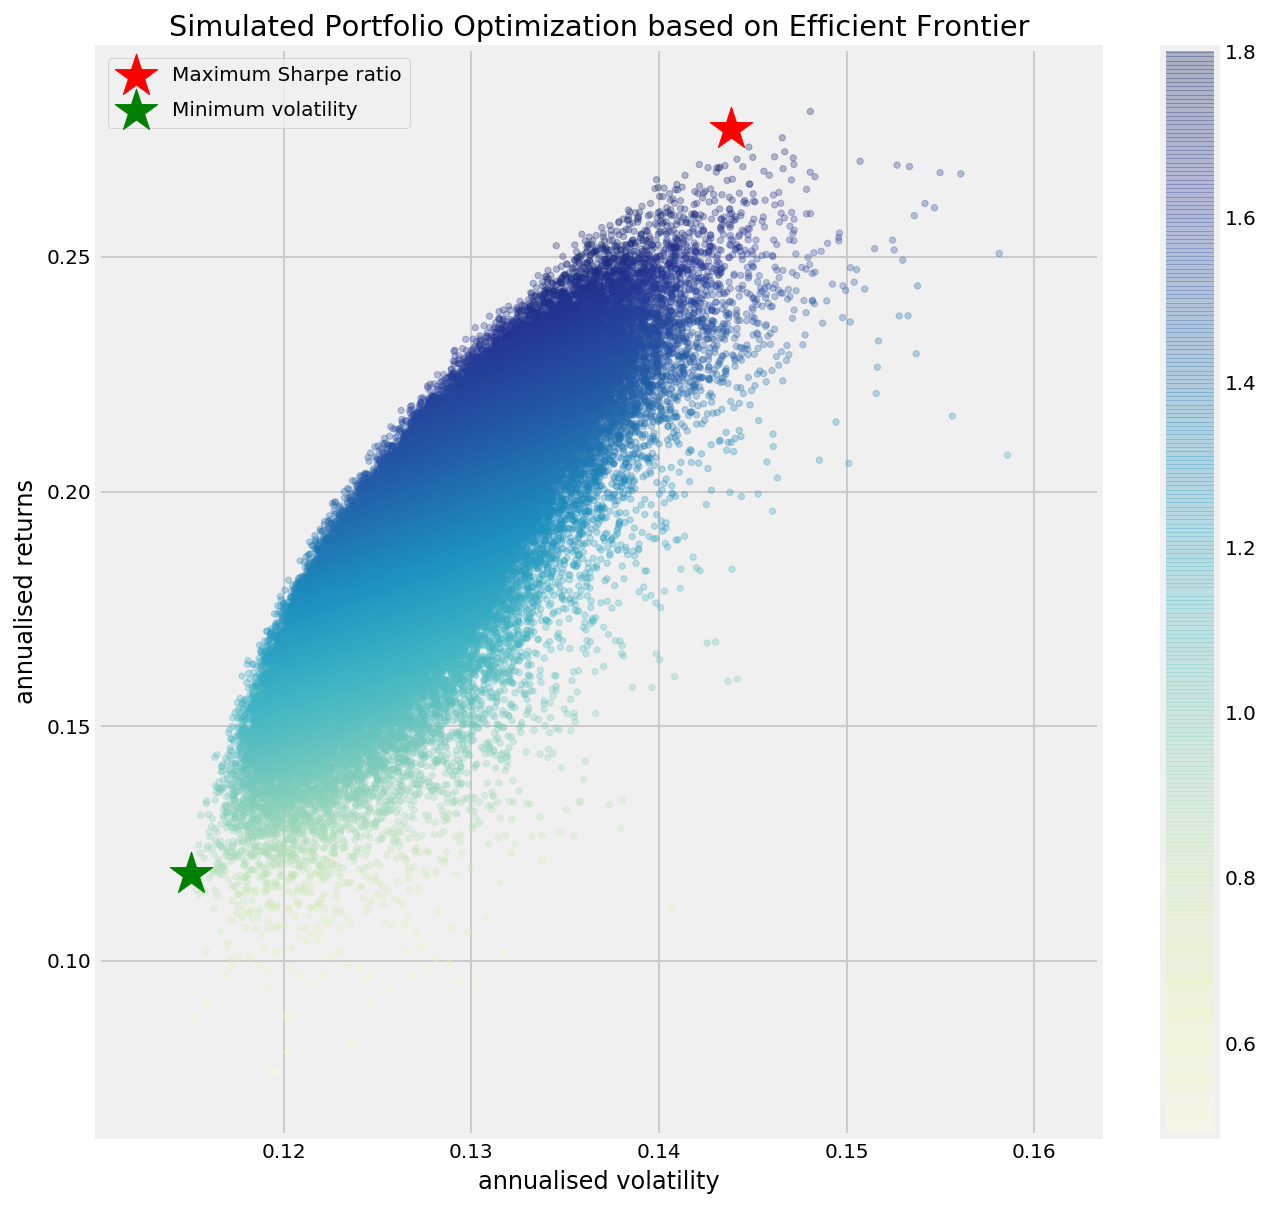

In [344]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)
print ("-"*80)
print("\n\n***It is a optimization base on the past performance in return***")

In [345]:
def con1(x):
    return p.sum(x) - 1

In [346]:
constraints = {'type': 'eq', 'fun': con1}

In [347]:

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [348]:

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [349]:

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [350]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, return_target=0):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    if return_target!=0:
        target_min_vol = efficient_return(expected_returns, cov_matrix, return_target)
        target_sdp_min, target_rp_min = portfolio_annualised_performance(target_min_vol['x'], mean_returns, cov_matrix)
        target_min_vol_allocation = pd.DataFrame(target_min_vol.x,index=table.columns,columns=['allocation'])
        target_min_vol_allocation.allocation = [round(i*100,2)for i in target_min_vol_allocation.allocation]
        target_min_vol_allocation = target_min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    if return_target!=0:
        print ("-"*80)
        print ("Minimum Volatility of The Target Return Portfolio Allocation\n")
        print ("Annualised Return:", round(target_rp_min,2))
        print ("Annualised Volatility:", round(target_sdp_min,2))
        print ("\n")
        print (target_min_vol_allocation)
    
    plt.figure(figsize=(10, num_stocks))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    if return_target!=0:
        plt.scatter(efficient_return(expected_returns, cov_matrix, return_target).fun, return_target, marker='*',color='b',s=500, label='Minimum volatility of the target return')
        target = np.linspace(rp_min, max(expected_daily_returns)*252, 50)
    else:
        target = np.linspace(rp_min, max(mean_returns)*252, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.15


             AAPL   AMZN   CSCO  CVS  DIS  GOOGL    JPM  MSFT     V  WFC
allocation  16.64  22.17  14.71  0.0  0.0    0.0  32.92  3.91  9.65  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.11


            AAPL  AMZN  CSCO    CVS   DIS  GOOGL  JPM  MSFT    V   WFC
allocation   6.3  2.56  7.11  18.38  30.9  18.96  0.0   0.0  8.3  7.48
--------------------------------------------------------------------------------


***It is a optimization base on the past performance in return***


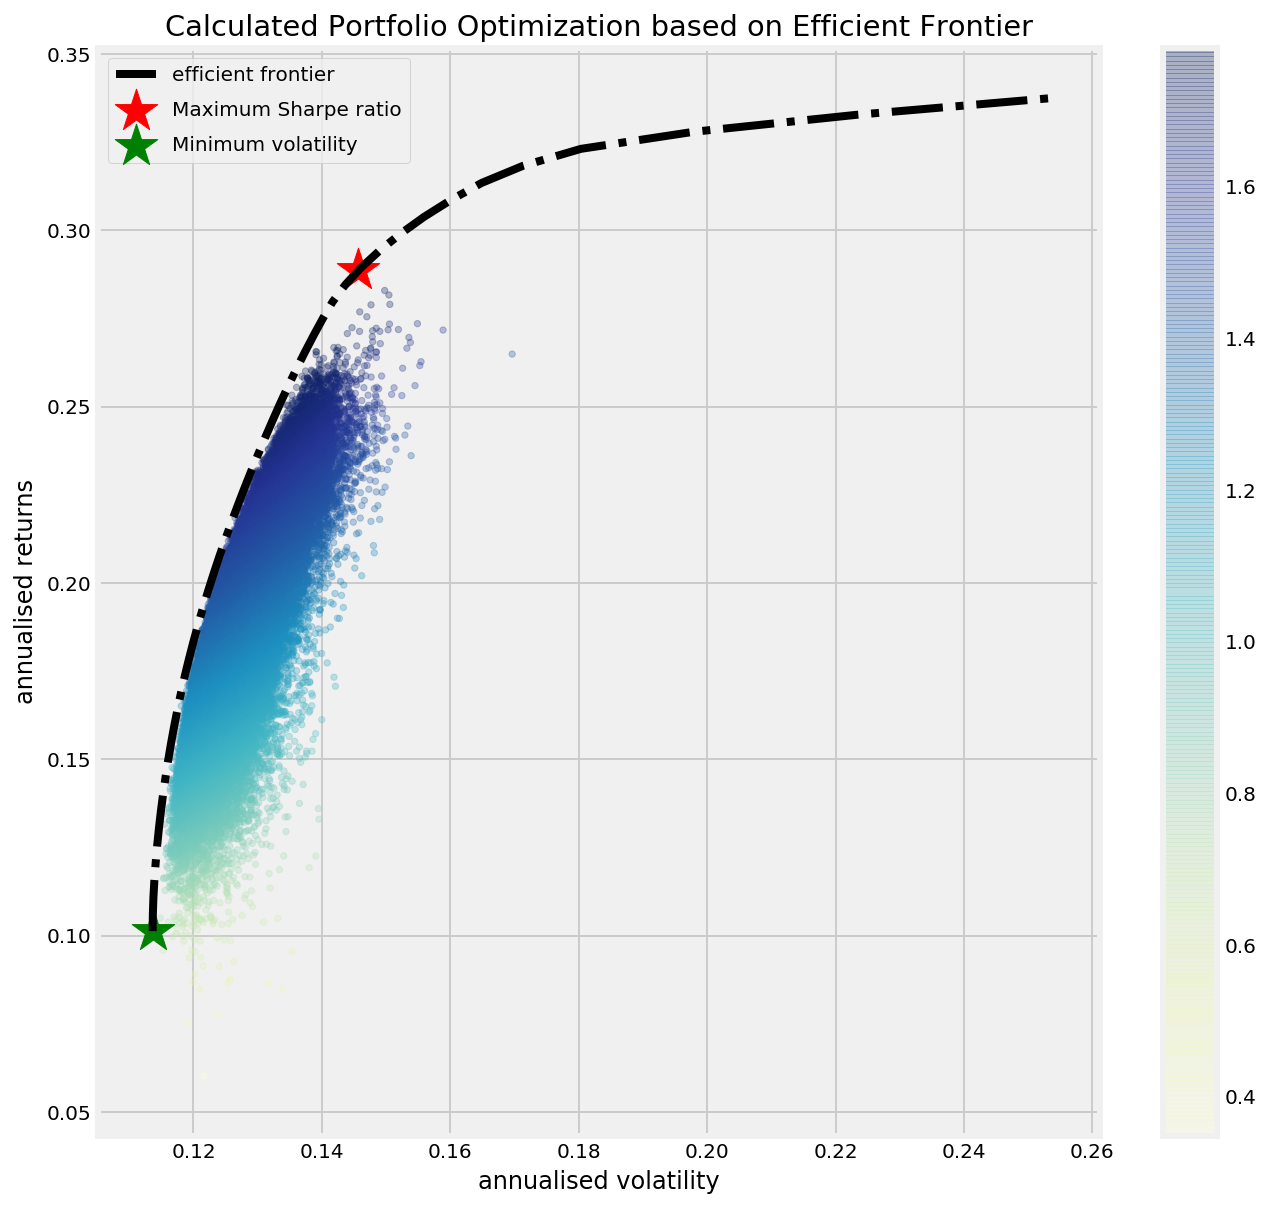

In [351]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)
print ("-"*80)
print("\n\n***It is a optimization base on the past performance in return***")

In [352]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate, return_target=0):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    if return_target!=0:
        target_min_vol = efficient_return(expected_returns, cov_matrix, return_target)
        target_sdp_min, target_rp_min = portfolio_annualised_performance(target_min_vol['x'], mean_returns, cov_matrix)
        target_min_vol_allocation = pd.DataFrame(target_min_vol.x,index=table.columns,columns=['allocation'])
        target_min_vol_allocation.allocation = [round(i*100,2)for i in target_min_vol_allocation.allocation]
        target_min_vol_allocation = target_min_vol_allocation.T
    
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    if return_target!=0:
        print ("-"*80)
        print ("Minimum Volatility of The Target Return Portfolio Allocation\n")
        print ("Annualised Return:", round(target_rp_min,2))
        print ("Annualised Volatility:", round(target_sdp_min,2))
        print ("\n")
        print (target_min_vol_allocation)
    
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, num_stocks))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    if return_target!=0:
        plt.scatter(efficient_return(expected_returns, cov_matrix, return_target).fun, return_target, marker='*',color='b',s=500, label='Minimum volatility of the target return')
        target = np.linspace(rp_min, max(expected_daily_returns)*252, 50)
    else:
        target = np.linspace(rp_min, max(mean_returns)*252, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.15


             AAPL   AMZN   CSCO  CVS  DIS  GOOGL    JPM  MSFT     V  WFC
allocation  16.64  22.17  14.71  0.0  0.0    0.0  32.92  3.91  9.65  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.11


            AAPL  AMZN  CSCO    CVS   DIS  GOOGL  JPM  MSFT    V   WFC
allocation   6.3  2.56  7.11  18.38  30.9  18.96  0.0   0.0  8.3  7.48
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : annuaised return 0.28 , annualised volatility: 0.21
AMZN : annuaised return 0.34 , annualised volatility: 0.25
CSCO : annuaised return 0.24 , annualised volatility: 0.19
CVS : annuaised return -0.1 , annualised volatility: 0.22
DI

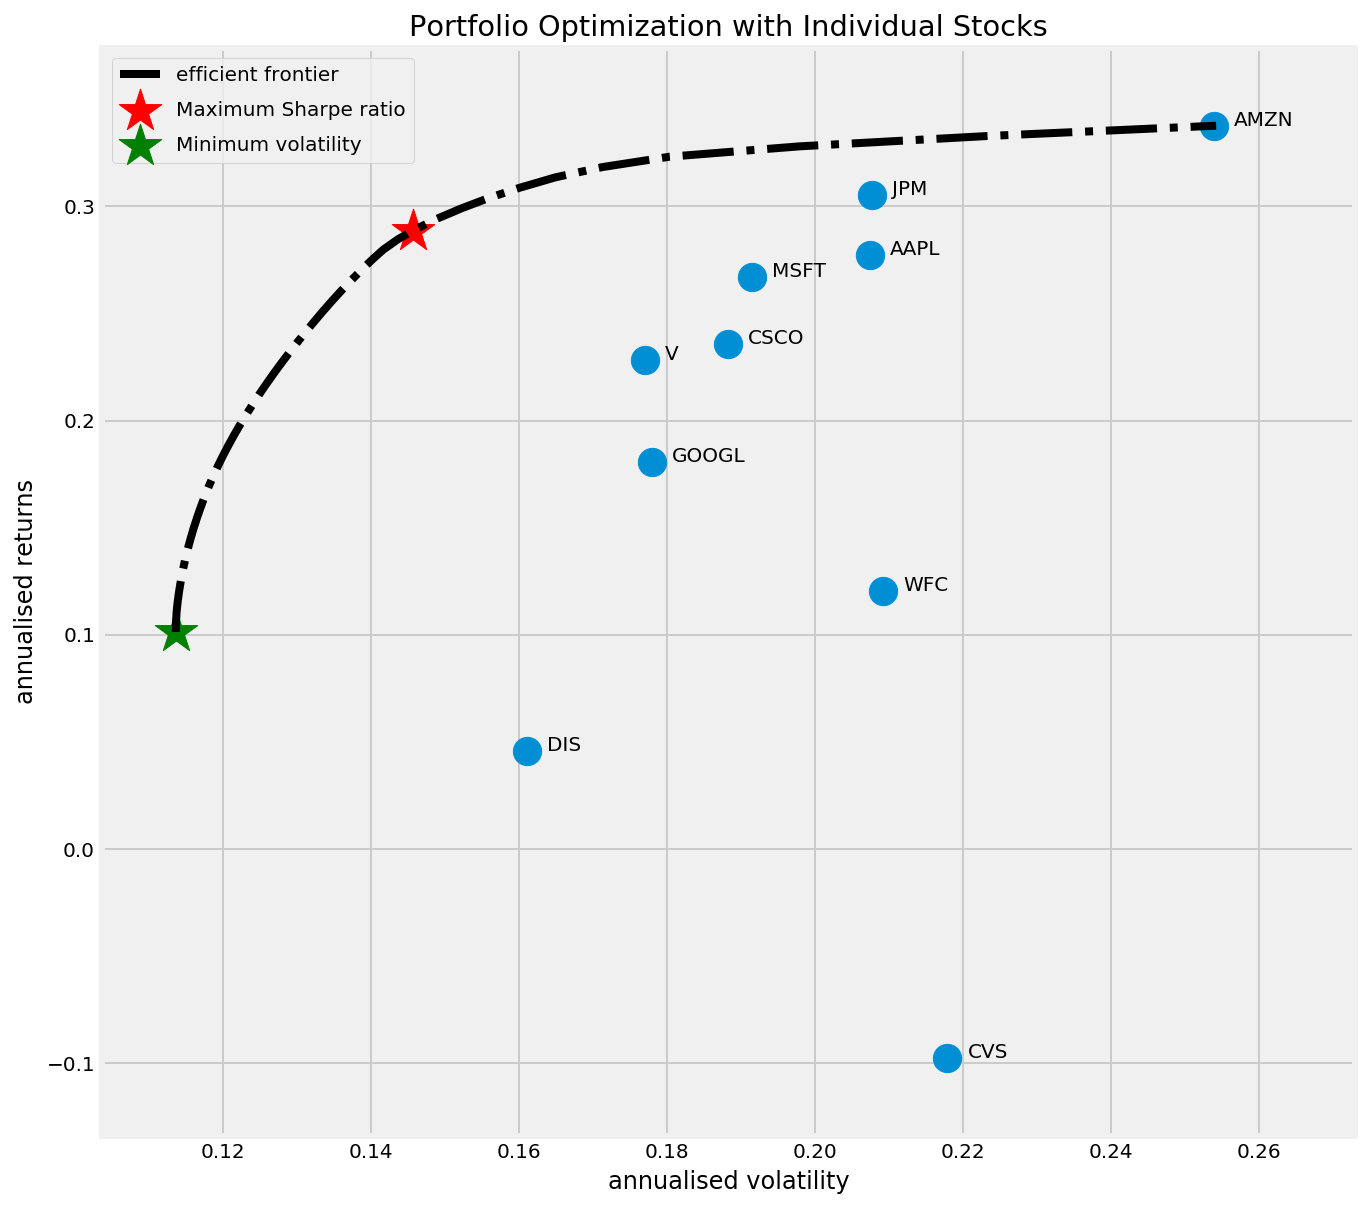

In [353]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)
print ("-"*80)
print("\n\n***It is a optimization base on the past performance in return***")

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.28
Annualised Volatility: 0.14


            AAPL   AMZN  CSCO    CVS   DIS  GOOGL    JPM  MSFT     V    WFC
allocation  5.67  27.25   5.5  24.01  3.04   0.97  18.46  3.11  0.59  11.39
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.17
Annualised Volatility: 0.12


            AAPL  AMZN  CSCO    CVS   DIS  GOOGL  JPM  MSFT      V  WFC
allocation  5.53  2.17  3.75  20.49  24.2  19.44  2.4   3.3  11.73  7.0
--------------------------------------------------------------------------------
Minimum Volatility of The Target Return Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.12


            AAPL   AMZN  CSCO    CVS    DIS  GOOGL  JPM  MSFT     V    WFC
allocation  9.21  13.01  6.18  24.23  23.94   9.02  0.0   0.0  0.27  14.14


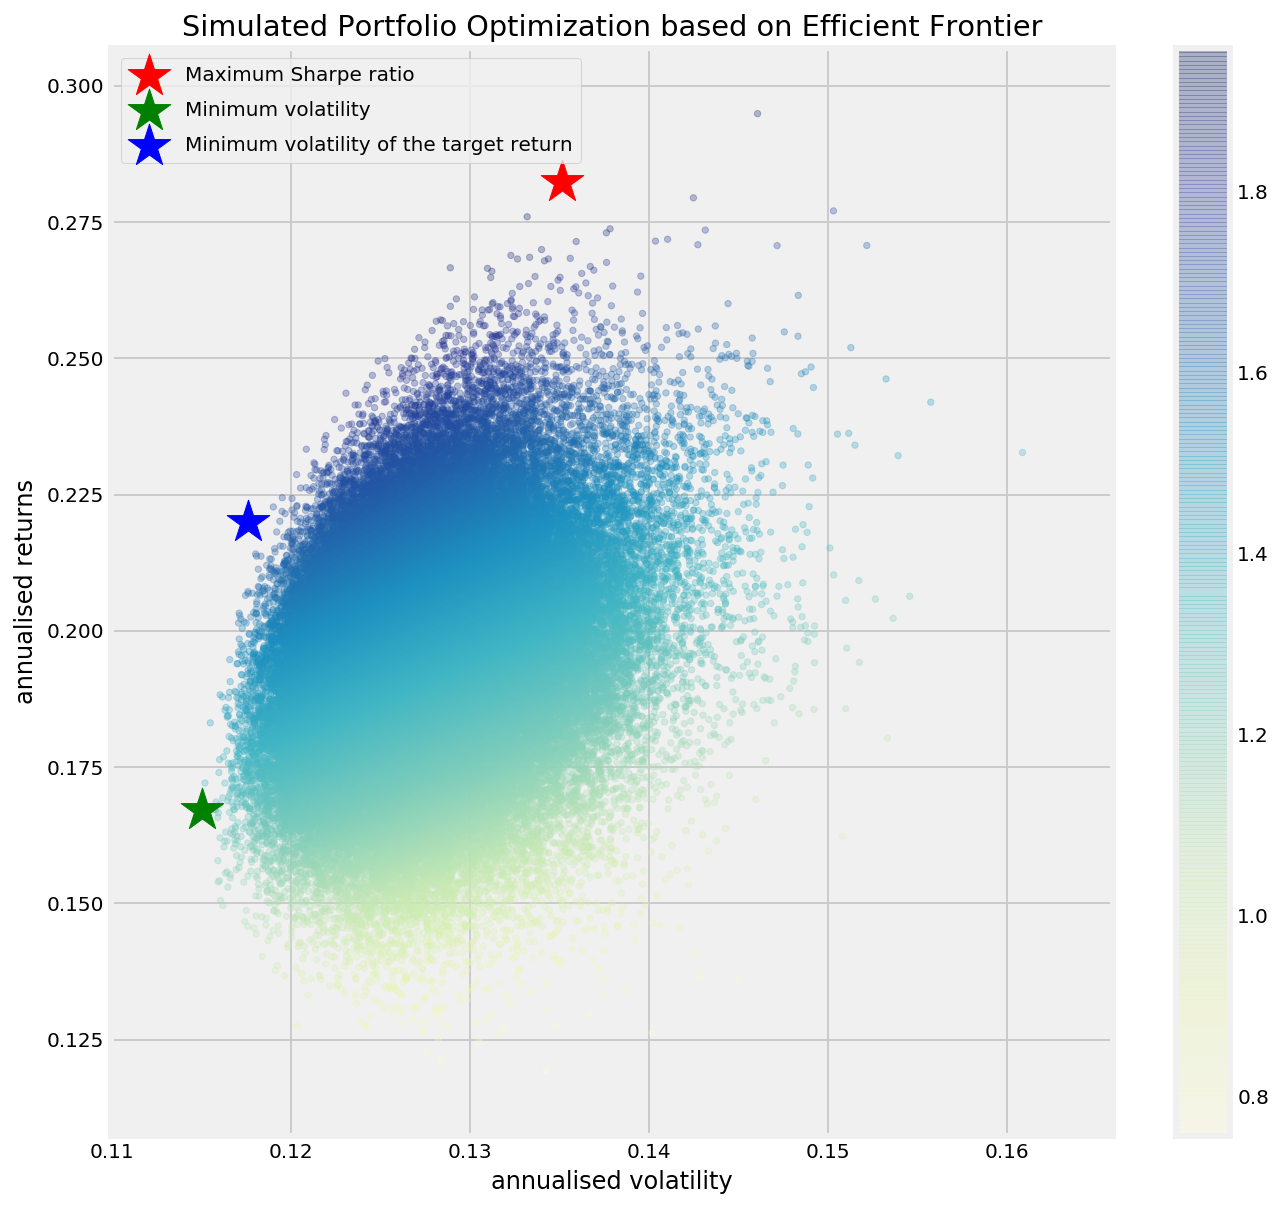

In [354]:
display_simulated_ef_with_random(expected_returns, cov_matrix, num_portfolios
, risk_free_rate, return_target)



--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.32
Annualised Volatility: 0.14


            AAPL   AMZN  CSCO    CVS  DIS  GOOGL   JPM  MSFT    V    WFC
allocation  2.36  34.83   0.0  35.45  0.0    0.0  5.21   0.0  0.0  22.16
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.11


            AAPL  AMZN  CSCO    CVS   DIS  GOOGL  JPM  MSFT    V   WFC
allocation   6.3  2.56  7.11  18.38  30.9  18.96  0.0   0.0  8.3  7.48
--------------------------------------------------------------------------------
Minimum Volatility of The Target Return Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.12


            AAPL   AMZN  CSCO    CVS    DIS  GOOGL  JPM  MSFT     V    WFC
allocation  9.21  13.01  6.18  24.23  23.94   9.02  0.0   0.0  0.27  14.14


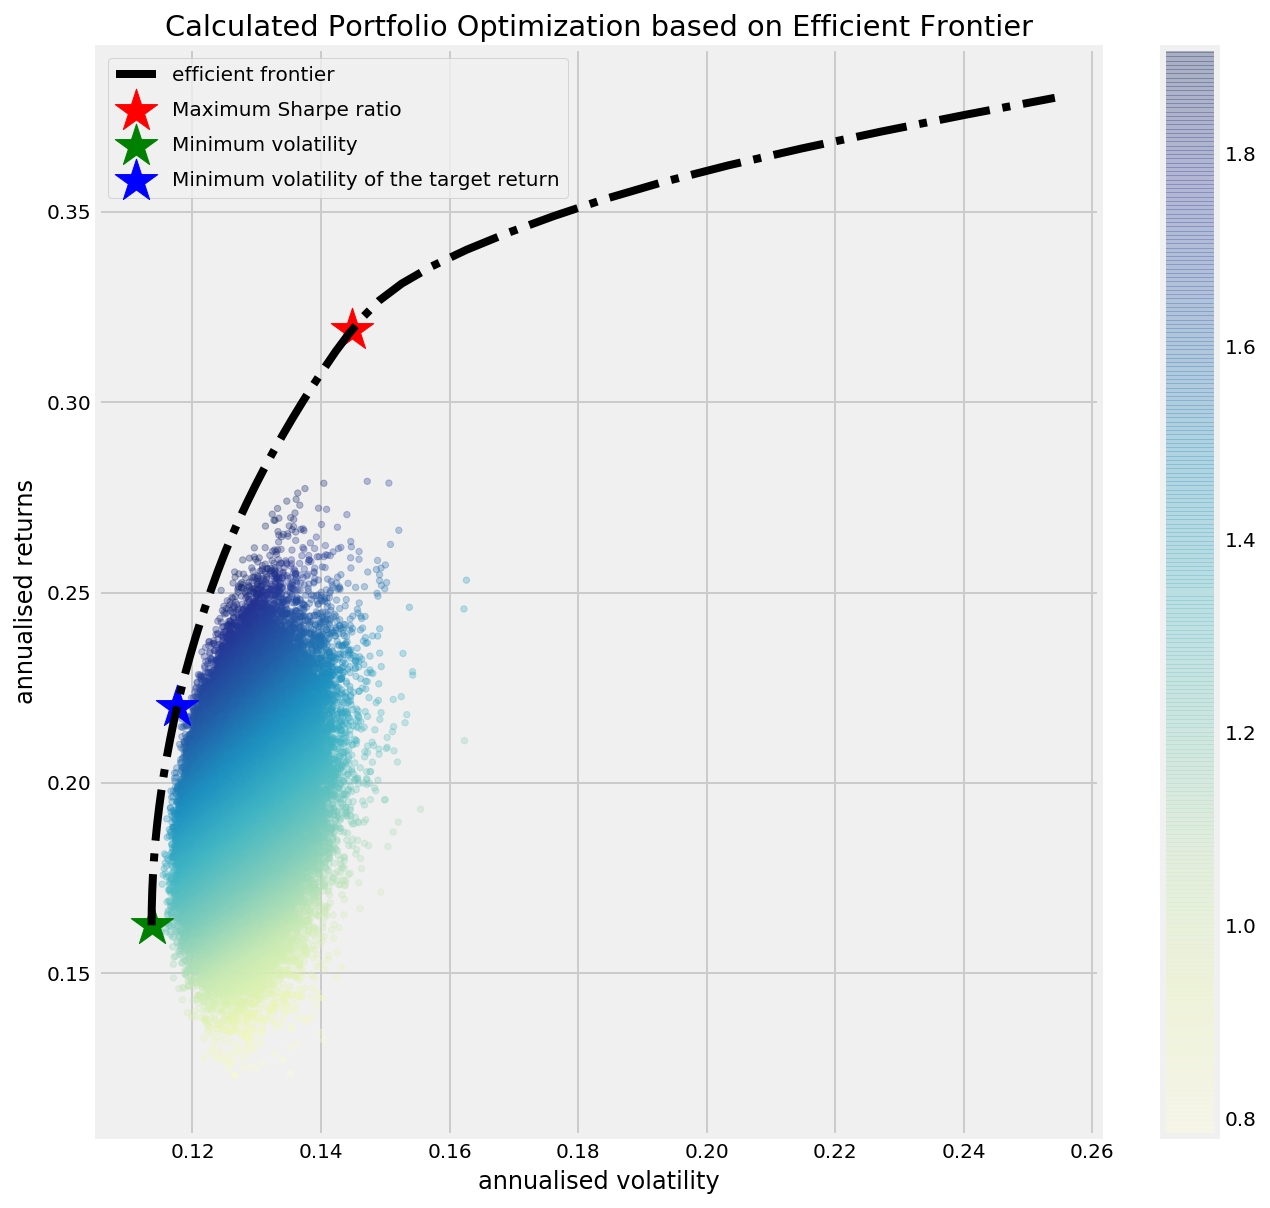

In [355]:
display_calculated_ef_with_random(expected_returns, cov_matrix, num_portfolios, risk_free_rate, return_target)



--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.32
Annualised Volatility: 0.14


            AAPL   AMZN  CSCO    CVS  DIS  GOOGL   JPM  MSFT    V    WFC
allocation  2.36  34.83   0.0  35.45  0.0    0.0  5.21   0.0  0.0  22.16
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.11


            AAPL  AMZN  CSCO    CVS   DIS  GOOGL  JPM  MSFT    V   WFC
allocation   6.3  2.56  7.11  18.38  30.9  18.96  0.0   0.0  8.3  7.48
--------------------------------------------------------------------------------
Minimum Volatility of The Target Return Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.12


            AAPL   AMZN  CSCO    CVS    DIS  GOOGL  JPM  MSFT     V    WFC
allocation  9.21  13.01  6.18  24.23  23.94   9.02  0.0   0.0  0.27  14.14
-----------

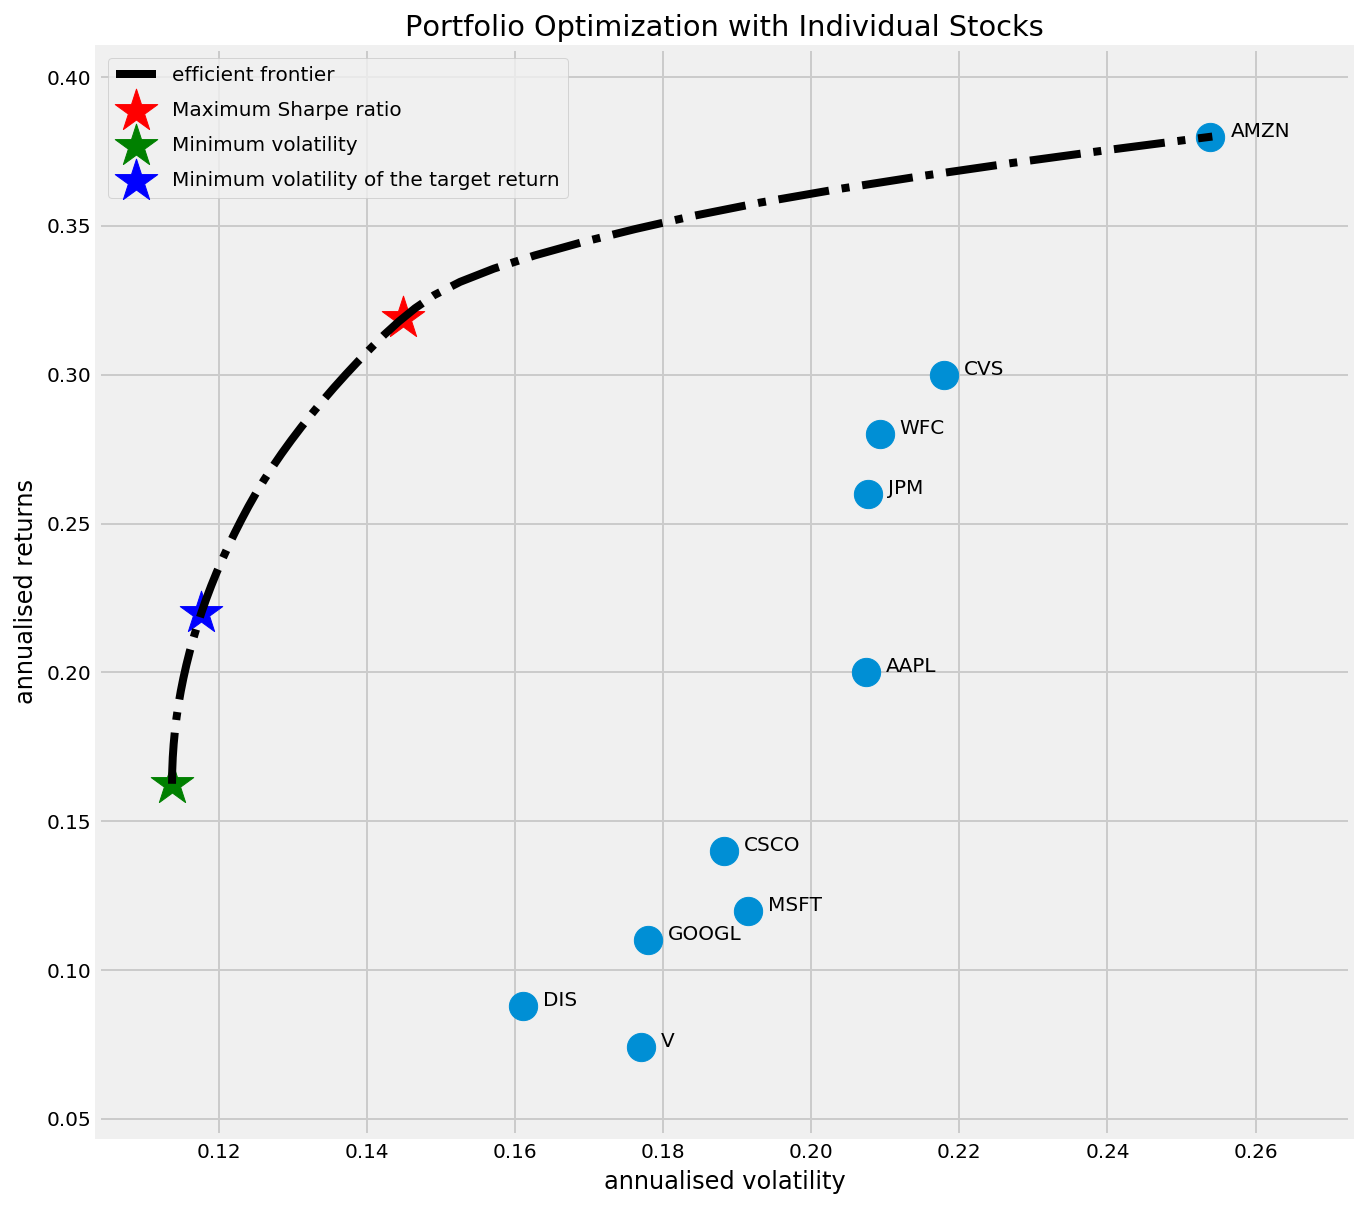

In [356]:
display_ef_with_selected(expected_returns, cov_matrix, risk_free_rate, return_target)